In [13]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm 
import matplotlib.pyplot as plt

In [14]:
def generate_dft_matrix(N):
    n = torch.arange(N)
    k = n.view(N, 1)
    omega = torch.exp(-2j * torch.pi * k * n / N).real.to(torch.float32)
    return omega


In [15]:
# Создаем классы для каждого блока UNet

# Класс для двух последовательных сверток с функцией активации ReLU
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DFT = generate_dft_matrix(1024).to(device)
class DoubleConv1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv1d, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Класс для уменьшения размерности входного тензора вдвое
class Down1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down1d, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv1d(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Класс для увеличения размерности входного тензора вдвое
class Up1d(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up1d, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='linear', align_corners=True)
        else:
            self.up = nn.ConvTranspose1d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv1d(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, [diff // 2, diff - diff // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Класс для выходного слоя
class OutConv1d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс для всей сети UNet
class UNet1d(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet1d, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv1d(n_channels, 64)
        self.down1 = Down1d(64, 128)
        self.down2 = Down1d(128, 256)
        self.down3 = Down1d(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down1d(512, 1024 // factor)
        self.up1 = Up1d(1024, 512 // factor, bilinear)
        self.up2 = Up1d(512, 256 // factor, bilinear)
        self.up3 = Up1d(256, 128 // factor, bilinear)
        self.up4 = Up1d(128, 64, bilinear)
        self.outc = OutConv1d(64, n_classes)

    def forward(self, x):
        x = torch.fft.rfft(x, dim=2).real
        
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        logits = torch.fft.irfft(logits, dim=2).real
        
        return logits

# Создаем экземпляр модели и выводим ее архитектуру
model = UNet1d(n_channels=1, n_classes=1) 
print(model)

UNet1d(
  (inc): DoubleConv1d(
    (double_conv): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU(inplace=True)
    )
  )
  (down1): Down1d(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1d(
        (double_conv): Sequential(
          (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): ReLU(inplace=True)
          (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
          (3): ReLU(inplace=True)
        )
      )
    )
  )
  (down2): Down1d(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv1d(
        (double_conv): Sequential(
          (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
       

In [16]:
def circ_mul(C, x):
    """
    Умножение циркулянтной матрицы C на вектор x с использованием FFT.
    
    C: Циркулянтная матрица (представлена первым столбцом)
    x: Вектор для умножения
    """
    # Выполняем умножение с использованием FFT
    result = torch.fft.ifft(torch.fft.fft(C) * torch.fft.fft(x))
    
    return result

def sim_toeplitz_mul(A, x):
    """
    Умножение симметричной матрицы A на вектор x с использованием FFT.
    
    A: Матрица (представлена первой строкой)
    x: Вектор для умножения
    """
    # Преобразуем симметричную матрицу в циркулянтную
    C = torch.cat((A, A[1:].flip(0)), dim=0)
    x_c = torch.cat((x, torch.zeros(x.shape[-1]-1)), dim=0)
    print(A.flip(0))
    # Выполняем умножение с использованием FFT
    result = circ_mul(C, x_c)
    
    return result[:x.size(0)]


class SpecRadLoss(nn.Module):

    # using rho(A) = lim_n sup ||x|| = 1 || A^n x ||^1/n

    def __init__(self, n=10, n_samples=100):

        super().__init__()
        self.n = n
        self.n_samples = n_samples

    def forward(self, x, circ):

        # x shape: (N, 1, L)
        length = x.shape[-1]

        sphere_points = torch.randn((length, self.n_samples))
        sphere_points /= torch.norm(sphere_points, dim=0)
        sphere_points = sphere_points.repeat(x.shape[0], 1, 1)

        # sphere_points shape: (L, 1, n_samples)

        for i in range(self.n):

            sphere_points = sphere_points - sim_toeplitz_mul(x, circ_mul(circ, sphere_points))

        vals = torch.pow(torch.max(torch.norm(sphere_points, dim=1), dim=1)[0], 1/self.n)
        
        return torch.mean(vals)


In [17]:
# Пример циркулянтной матрицы и вектора
C = torch.tensor([1, 2, 3], dtype=torch.float32)
x = torch.tensor([1, 2, 3], dtype=torch.float32)

# Умножение циркулянтной матрицы на вектор
result_circ = circ_mul(C, x)
print("Результат умножения циркулянтной матрицы на вектор:")
print(result_circ)

# Пример симметричной матрицы и вектора
A = torch.tensor([1, 2, 3], dtype=torch.float32)

# Умножение симметричной матрицы на вектор
result_toeplitz = sim_toeplitz_mul(A, x)
print("Результат умножения симметричной матрицы на вектор:")
print(result_toeplitz)

Результат умножения циркулянтной матрицы на вектор:
tensor([13.+0.j, 13.+0.j, 10.+0.j])
tensor([3., 2., 1.])
Результат умножения симметричной матрицы на вектор:
tensor([14.+0.j, 10.+0.j, 10.+0.j])


In [18]:
# Пример класса датасета

class ExampleDataset(Dataset):
    def __init__(self, filedata, filetargets, if_test=False):
        # Загрузка данных
        DATA = torch.load(filedata, weights_only=True).to(device).unsqueeze(1).imag
        TARGETS = torch.load(filetargets, weights_only=True).to(device).unsqueeze(1).imag
        
        # Выбор 80% данных для обучения или 20% для тестирования
        data_n = 0.8 * len(DATA)
        if if_test == False:
            self.data = DATA[:int(data_n)]
            self.targets = TARGETS[:int(data_n)]
        else:
            self.data = DATA[int(data_n):]
            self.targets = TARGETS[int(data_n):]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


# Создание датасета и загрузчика данных
folder = "/Users/shuramakarenko/LocalDocs/Workspace/Neiro_toyeplitz/DATA/Matrix1024"
filedata = folder + "/Samples.pth"
filetargets = folder + "/Targets.pth"
dataset = ExampleDataset(filedata, filetargets)
datatest = ExampleDataset(filedata, filetargets, if_test=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
dataloader_test = DataLoader(datatest, batch_size=128, shuffle=True)

# Создание модели
model = UNet1d(n_channels=1, n_classes=1).to(device)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Цикл обучения
num_epochs = 10
train_losses = []
test_losses = []
test_relative_errors = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(dataloader):
        optimizer.zero_grad()                   # Обнуление градиентов
        outputs = model(inputs)                 # Прямой проход
        loss = criterion(outputs, targets)      # Вычисление потерь
        loss.backward()                         # Обратный проход
        optimizer.step()                        # Обновление параметров
        running_loss += loss.item()
    
    train_loss = running_loss / len(dataloader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Оценка на тестовой выборке
    model.eval()  # Перевод модели в режим оценки
    test_loss = 0.0
    all_targets = []
    all_outputs = []
    with torch.no_grad():  # Отключение вычисления градиентов
        for inputs, targets in dataloader_test:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            all_targets.extend(targets.squeeze(1).cpu().numpy())
            all_outputs.extend(outputs.squeeze(1).cpu().numpy())
    test_loss /= len(dataloader_test)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Оценка качества модели
    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)
    rel_error = np.mean(np.linalg.norm(all_targets - all_outputs, axis=1, ord = 2)/np.linalg.norm(all_targets, axis=1, ord = 2))
    test_relative_errors.append(rel_error)
    print(f'Epoch {epoch+1}/{num_epochs}, Test relative error: {rel_error}')

print("Обучение завершено")


torch.Size([10000, 1, 1024])
torch.Size([10000, 1, 1024])


100%|██████████| 63/63 [00:09<00:00,  6.39it/s]


Epoch 1/10, Training Loss: 1.2410252190694871e-05
Epoch 1/10, Test Loss: 3.2757451293718987e-06
Epoch 1/10, Test relative error: 0.3124808371067047


100%|██████████| 63/63 [00:09<00:00,  6.73it/s]


Epoch 2/10, Training Loss: 8.606335134641446e-07
Epoch 2/10, Test Loss: 1.76408091245861e-07
Epoch 2/10, Test relative error: 0.12332334369421005


100%|██████████| 63/63 [00:09<00:00,  6.66it/s]


Epoch 3/10, Training Loss: 1.3559612500196794e-07
Epoch 3/10, Test Loss: 8.051547584209118e-08
Epoch 3/10, Test relative error: 0.09582076966762543


100%|██████████| 63/63 [00:09<00:00,  6.48it/s]


Epoch 4/10, Training Loss: 8.321451030186591e-08
Epoch 4/10, Test Loss: 6.803362917473521e-08
Epoch 4/10, Test relative error: 0.08767750859260559


100%|██████████| 63/63 [00:10<00:00,  6.29it/s]


Epoch 5/10, Training Loss: 7.236503950566874e-08
Epoch 5/10, Test Loss: 6.50686644565468e-08
Epoch 5/10, Test relative error: 0.09109073877334595


100%|██████████| 63/63 [00:10<00:00,  6.19it/s]


Epoch 6/10, Training Loss: 6.822593661807347e-08
Epoch 6/10, Test Loss: 6.36072734483406e-08
Epoch 6/10, Test relative error: 0.08593959361314774


100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Epoch 7/10, Training Loss: 6.62631699070076e-08
Epoch 7/10, Test Loss: 6.244351724582486e-08
Epoch 7/10, Test relative error: 0.08292596787214279


100%|██████████| 63/63 [00:09<00:00,  6.67it/s]


Epoch 8/10, Training Loss: 6.503916079424694e-08
Epoch 8/10, Test Loss: 6.355624426745976e-08
Epoch 8/10, Test relative error: 0.08188541978597641


100%|██████████| 63/63 [00:09<00:00,  6.69it/s]


Epoch 9/10, Training Loss: 6.40307501412064e-08
Epoch 9/10, Test Loss: 6.080890435633535e-08
Epoch 9/10, Test relative error: 0.081741563975811


100%|██████████| 63/63 [00:09<00:00,  6.70it/s]


Epoch 10/10, Training Loss: 6.279789939555254e-08
Epoch 10/10, Test Loss: 5.986835027727011e-08
Epoch 10/10, Test relative error: 0.07883729785680771
Обучение завершено


In [24]:
model.eval()
np.set_printoptions(linewidth=np.inf)

with torch.no_grad():
    for inputs, targets in dataloader_test:
        outputs = model(inputs)
        print(f'Inputs: {inputs.squeeze(1)[0].cpu().numpy()[:10]}')
        print(f'Targets: {targets.squeeze(1)[0].cpu().numpy()[:10]}')
        print(f'Outputs: {outputs.squeeze(1)[0].cpu().numpy()[:10]}')
        break



Inputs: [-1.1044984e-01  3.0671200e-03  4.0791716e-04  1.2231755e-04  5.1820927e-05  2.6584363e-05  1.5400881e-05  9.7047578e-06  6.5041472e-06  4.5693801e-06]
Targets: [-1.10449843e-01  3.06412484e-03  4.07120446e-04  1.21959194e-04  5.16185028e-05  2.64545561e-05  1.53106412e-05  9.63841649e-06  6.45333375e-06  4.52921950e-06]
Outputs: [-1.1066459e-01  1.5206811e-03  4.5387307e-04  4.0671948e-05  2.7479432e-04 -7.3094775e-06  2.5618525e-04 -1.5597974e-05  2.5127089e-04 -1.7918501e-05]


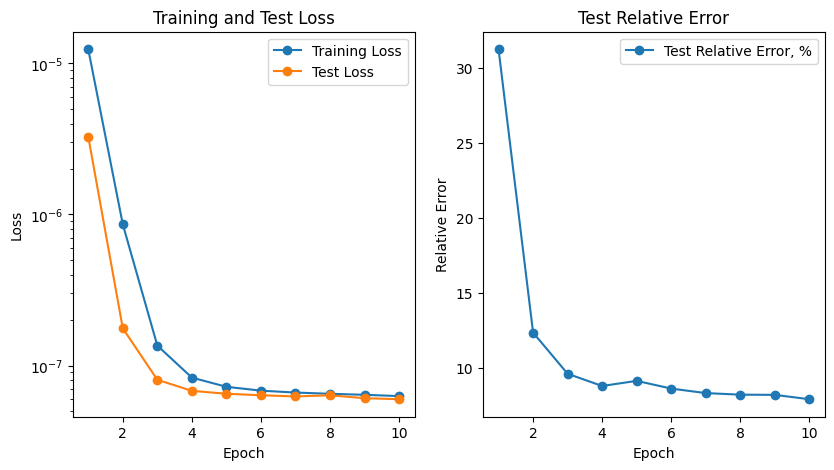

In [25]:
# Построение графиков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.yscale('log')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), np.array(test_relative_errors)*100, label='Test Relative Error, %', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Relative Error')
plt.title('Test Relative Error')
plt.legend()
